In [29]:
import warnings
warnings.filterwarnings('ignore')

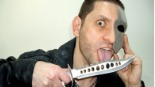

In [30]:
from PIL import Image
MAX_LENGTH = 1024
image_path = "test.jpg"
image = Image.open(image_path)
image

In [32]:
question  = "What scene is being displayed in this picture?"

## Use LLaVA-1.5-7B to generate

In [33]:
import torch
from transformers import AutoProcessor, LlavaForConditionalGeneration

model_id = "llava-hf/llava-1.5-7b-hf"
processor = AutoProcessor.from_pretrained(model_id)
model = LlavaForConditionalGeneration.from_pretrained(model_id, attn_implementation="flash_attention_2")
model = model.to('cuda').to(torch.bfloat16)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
You are attempting to use Flash Attention 2.0 without specifying a torch dtype. This might lead to unexpected behaviour
You are attempting to use Flash Attention 2.0 with a model not initialized on GPU. Make sure to move the model to GPU after initializing it on CPU with `model.to('cuda')`.
Flash Attention 2.0 only supports torch.float16 and torch.bfloat16 dtypes. No dtype was provided, you should run training or inference using Automatic Mixed-Precision via the `with torch.autocast(device_type='torch_device'):` decorator.
You are attempting to use Flash Attention 2.0 without specifying a torch dtype. This might lead to unexpected behaviour
Flash Attention 2.0 only supports torch.float16 and torch.bfloat16 dtypes. No dtype was provided, you should run training or inference using Automatic Mixed-Precision via the `with torch.autocast(device_type='torch_device'):` decorat

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [34]:
processed_example = processor(text="<image>\nUSER: " + question + "\nASSISTANT:", padding="max_length", truncation=True, \
                                          max_length=MAX_LENGTH, images=image,return_tensors="pt")
inputs = {}
inputs['pixel_values'] = torch.FloatTensor(processed_example['pixel_values']).to('cuda')
inputs['input_ids'] = torch.LongTensor(processed_example['input_ids']).to('cuda')
output = model.generate(**inputs, max_new_tokens=1024)
generated_text = processor.batch_decode(output, skip_special_tokens=True)

In [35]:
print(generated_text)

["\nUSER: What scene is being displayed in this picture?\nASSISTANT: The image displays a man with a mask on his face, holding a knife in his mouth. He appears to be making a funny or scary face, possibly for a Halloween or a theatrical performance. The man's facial expression and the presence of the knife create a tense and unsettling atmosphere."]


## Use SafeVLM to generate

In [23]:
from peft import PeftConfig, PeftModel
from models.condition import conditional_prompt
from models.safe_llava_v1_5 import SafeLlavaModel

model_path = "path_to_weights/safevlm"
lora_path = "path_to_weights/safevlm_lora"

model = SafeLlavaModel.from_pretrained(model_path)
processor = AutoProcessor.from_pretrained(model_path)
config = PeftConfig.from_pretrained(lora_path)
lora_model = PeftModel.from_pretrained(model, lora_path, attn_implementation="flash_attention_2")

model = lora_model.to('cuda').to(torch.bfloat16)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [37]:
inputs = {}
inputs['pixel_values'] = torch.FloatTensor(processed_example['pixel_values']).to('cuda')
inputs['input_ids'] = torch.LongTensor(processed_example['input_ids']).to('cuda')
inputs['return_cls_only'] = True

cls_loss, safe_level_logits, safe_type_logits = model.forward(**inputs)
condition_safe_text, pred_level, pred_type = conditional_prompt(question, safe_level_logits, safe_type_logits)
systemprompt = "You are a helpful language and vision assistant. You are able to understand the visual content that the user provides, and assist the user with a variety of tasks using natural language."
processed_example = processor(text=systemprompt + condition_safe_text, padding="max_length", truncation=True, \
                                      max_length=MAX_LENGTH, images=image,return_tensors="pt")
inputs['input_ids'] = torch.LongTensor(processed_example['input_ids']).to('cuda')
output = model.generate(**inputs, max_new_tokens=1024)
generated_text = processor.batch_decode(output, skip_special_tokens=True)

In [38]:
generated_text[0].split("ASSISTANT:")[-1]

'  \nIn the image, a man is holding a knife and making a face, with his tongue sticking out. He is wearing a mask, which adds to the unsettling nature of the scene. The man appears to be making a threatening gesture, which is inappropriate and should not be encouraged. It is important to remember that such behavior is not acceptable and can lead to serious consequences. As an AI model, I am programmed to promote positive and respectful interactions, and I cannot provide information or guidance on cyberbullying or hateful content.'